## Train

In [1]:
import argparse
import os
import logging
import sys
import itertools

import torch
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR

from vision.utils.misc import str2bool, Timer, freeze_net_layers, store_labels
from vision.ssd.ssd import MatchPrior
from vision.ssd.vgg_ssd import create_vgg_ssd
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite
#
#from vision.datasets.voc_dataset import VOCDataset
from vision.datasets.NEU_dataset import VOCDataset
#from vision.datasets.open_images import OpenImagesDataset
#
from vision.nn.multibox_loss import MultiboxLoss
from vision.ssd.config import vgg_ssd_config
from vision.ssd.config import mobilenetv1_ssd_config
from vision.ssd.config import squeezenet_ssd_config
from vision.ssd.data_preprocessing import TrainAugmentation, TestTransform

print('Single Shot MultiBox Detector Training With Pytorch')

dataset_type = "voc"
datasets = "/home/taeho/다운로드/NEU-DET"
validation_dataset = "/home/taeho/다운로드/NEU-DET/test"
net = "vgg16-ssd"

# Params for SGD
lr = 1e-3
momentum = 0.9
weight_decay = 5e-4
gamma = 0.1
base_net_lr = None
extra_layers_lr = None

# Params for loading pretrained basenet or checkpoints.
base_net = "models/vgg16_reducedfc.pth"
pretrained_ssd = None
resume = None

# Scheduler
scheduler = "multi-step"

# Params for Multi-step Scheduler
milestones = "120,160"

# Params for Cosine Annealing
t_max = 120.0

# Train params
batch_size = 24
num_epochs = 2
num_workers = 4
validation_epochs = 5
debug_steps = 100
use_cuda = True
checkpoint_folder = 'models/'

#
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() and use_cuda else "cpu")

if use_cuda and torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("Use Cuda.")


def train(loader, net, criterion, optimizer, device, debug_steps=100, epoch=-1):
    net.train(True)
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    for i, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        confidence, locations = net(images)
        regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)  # TODO CHANGE BOXES
        loss = regression_loss + classification_loss
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
        if i and i % debug_steps == 0:
            avg_loss = running_loss / debug_steps
            avg_reg_loss = running_regression_loss / debug_steps
            avg_clf_loss = running_classification_loss / debug_steps
            logging.info(
                f"Epoch: {epoch}, Step: {i}, " +
                f"Average Loss: {avg_loss:.4f}, " +
                f"Average Regression Loss {avg_reg_loss:.4f}, " +
                f"Average Classification Loss: {avg_clf_loss:.4f}"
            )
            running_loss = 0.0
            running_regression_loss = 0.0
            running_classification_loss = 0.0


def test(loader, net, criterion, device):
    net.eval()
    running_loss = 0.0
    running_regression_loss = 0.0
    running_classification_loss = 0.0
    num = 0
    for _, data in enumerate(loader):
        images, boxes, labels = data
        images = images.to(device)
        boxes = boxes.to(device)
        labels = labels.to(device)
        num += 1

        with torch.no_grad():
            confidence, locations = net(images)
            regression_loss, classification_loss = criterion(confidence, locations, labels, boxes)
            loss = regression_loss + classification_loss

        running_loss += loss.item()
        running_regression_loss += regression_loss.item()
        running_classification_loss += classification_loss.item()
    return running_loss / num, running_regression_loss / num, running_classification_loss / num


#timer = Timer()
    
if net == 'vgg16-ssd':
    create_net = create_vgg_ssd
    config = vgg_ssd_config
else:
    print("No network")
    
        
train_transform = TrainAugmentation(config.image_size, config.image_mean, config.image_std)
target_transform = MatchPrior(config.priors, config.center_variance,
                              config.size_variance, 0.5)

test_transform = TestTransform(config.image_size, config.image_mean, config.image_std)

print("Prepare training datasets.")
datalist = []
if dataset_type == 'voc':
    dataset = VOCDataset(datasets, transform=train_transform,
                         target_transform=target_transform)
    label_file = os.path.join(checkpoint_folder, "neu-model-labels.txt")
    store_labels(label_file, dataset.class_names)
    num_classes = len(dataset.class_names)

else:
    print("No dataset_type")
    
datalist.append(dataset)
        
print("Stored labels into file neu-model-labels.txt.")
train_dataset = ConcatDataset(datalist)
print("Train dataset size: {}". format(len(train_dataset)))
train_loader = DataLoader(train_dataset, batch_size,
                          num_workers=num_workers,
                          shuffle=True)
    
print("Prepare Validation datasets.")
if dataset_type == "voc":
    val_dataset = VOCDataset(validation_dataset, transform=test_transform,
                             target_transform=target_transform, is_test=True)
        
print("validation dataset size: {}".format(len(val_dataset)))

val_loader = DataLoader(val_dataset, batch_size,
                        num_workers=num_workers,
                        shuffle=False)

print("Build network.")
net = create_net(num_classes)
min_loss = -10000.0
last_epoch = -1

base_net_lr = base_net_lr if base_net_lr is not None else lr
extra_layers_lr = extra_layers_lr if extra_layers_lr is not None else lr
    
params = [
    {'params': net.base_net.parameters(), 'lr': base_net_lr},
    {'params': itertools.chain(
        net.source_layer_add_ons.parameters(),
        net.extras.parameters()
    ), 'lr': extra_layers_lr},
    {'params': itertools.chain(
        net.regression_headers.parameters(),
        net.classification_headers.parameters()
    )}
]

#timer.start("Load Model")
if resume:
    print("Resume from the model")
    net.load(resume)
elif base_net:
    print("Init from base net")
    net.init_from_base_net(base_net)
elif pretrained_ssd:
    print("Init from pretrained ssd")
    net.init_from_pretrained_ssd(pretrained_ssd)
print()
#logging.info(f'Took {timer.end("Load Model"):.2f} seconds to load the model.')

net.to(DEVICE)

criterion = MultiboxLoss(config.priors, iou_threshold=0.5, neg_pos_ratio=3,
                         center_variance=0.1, size_variance=0.2, device=DEVICE)
optimizer = torch.optim.SGD(params, lr=lr, momentum=momentum,
                            weight_decay=weight_decay)
print("Learning rate:", lr, "Base net learning rate:", base_net_lr,
      "Extra Layers learning rate:", extra_layers_lr)

if scheduler == 'multi-step':
    print("Uses MultiStepLR scheduler.")
    milestones = [int(v.strip()) for v in milestones.split(",")]
    scheduler = MultiStepLR(optimizer, milestones=milestones,
                            gamma=0.1, last_epoch=last_epoch)
elif scheduler == 'cosine':
    print("Uses CosineAnnealingLR scheduler.")
    scheduler = CosineAnnealingLR(optimizer, t_max, last_epoch=last_epoch)
else:
    print("Unsupported Scheduler")
    

print("Start training from epoch 0.")
for epoch in range(last_epoch + 1, num_epochs):
    scheduler.step()
    train(train_loader, net, criterion, optimizer,
          device=DEVICE, debug_steps=debug_steps, epoch=epoch)
        
    if epoch % validation_epochs == 0 or epoch == num_epochs - 1:
        val_loss, val_regression_loss, val_classification_loss = test(val_loader, net, criterion, DEVICE)
        print("Epoch:", epoch, "\n", 
              "Validation Loss:", val_loss, "\n",
              "Validation Regression Loss:", val_regression_loss, "\n",
              "Validation Classification Loss:", val_classification_loss, "\n"
              )
        
        name = "vgg16-ssd" + "-Epoch-" + "%s"%epoch + "-Loss-" + "%s"%str(val_loss)[:7] + ".pth"
        model_path = os.path.join(checkpoint_folder, name)
        ##model_path = os.path.join(checkpoint_folder, f"{net}-Epoch-{epoch}-Loss-{val_loss}.pth")
        net.save(model_path)
        print("Saved model:", model_path)
        
        

Single Shot MultiBox Detector Training With Pytorch
Use Cuda.
Prepare training datasets.
Stored labels into file neu-model-labels.txt.
Train dataset size: 1439
Prepare Validation datasets.
validation dataset size: 360
Build network.
Init from base net

Learning rate: 0.001 Base net learning rate: 0.001 Extra Layers learning rate: 0.001
Uses MultiStepLR scheduler.
Start training from epoch 0.


/home/taeho/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 0 
 Validation Loss: 13.747037315368653 
 Validation Regression Loss: 2.9959357420603436 
 Validation Classification Loss: 10.751101716359456 

Saved model: models/vgg16-ssd-Epoch-0-Loss-13.7470.pth
Epoch: 1 
 Validation Loss: 8.035370063781738 
 Validation Regression Loss: 2.907026465733846 
 Validation Classification Loss: 5.128343645731608 

Saved model: models/vgg16-ssd-Epoch-1-Loss-8.03537.pth


## Eval

## Visualize

Inference time:  0.0030679702758789062
Found 2 objects. The output image is run_ssd_example_output.jpg


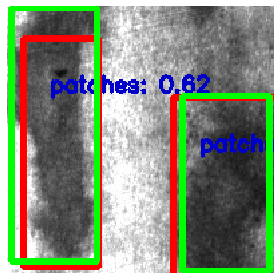

Inference time:  0.0036530494689941406
Found 3 objects. The output image is run_ssd_example_output.jpg


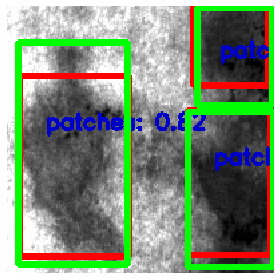

Inference time:  0.0037233829498291016
Found 3 objects. The output image is run_ssd_example_output.jpg


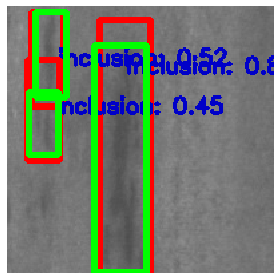

In [23]:
from vision.ssd.vgg_ssd import create_vgg_ssd, create_vgg_ssd_predictor
from vision.ssd.mobilenetv1_ssd import create_mobilenetv1_ssd, create_mobilenetv1_ssd_predictor
from vision.ssd.mobilenetv1_ssd_lite import create_mobilenetv1_ssd_lite, create_mobilenetv1_ssd_lite_predictor
from vision.ssd.squeezenet_ssd_lite import create_squeezenet_ssd_lite, create_squeezenet_ssd_lite_predictor
from vision.ssd.mobilenet_v2_ssd_lite import create_mobilenetv2_ssd_lite, create_mobilenetv2_ssd_lite_predictor
from vision.utils.misc import Timer
import cv2
import sys

import xml.etree.ElementTree as ET
import os
import matplotlib.pyplot as plt
%matplotlib inline

net_type = "vgg16-ssd"
model_path = "models/vgg16-ssd-Epoch-175-Loss-4.334773302078247.pth"
label_path = "models/neu-model-labels.txt"
#image_path = "data/patches_294.jpg"

class_names = [name.strip() for name in open(label_path).readlines()]

if net_type == 'vgg16-ssd':
    net = create_vgg_ssd(len(class_names), is_test=True)
    predictor = create_vgg_ssd_predictor(net, candidate_size=200)
    
else:
    print("The net type is wrong.")
    
net.load(model_path)


def image_print(image_path):
    orig_image = cv2.imread(image_path)
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    boxes, labels, probs = predictor.predict(image, 10, 0.4)


    for i in range(boxes.size(0)):
        box = boxes[i, :]
        cv2.rectangle(orig_image, (box[0], box[1]), (box[2], box[3]), (0, 0, 255), 4)
        #label = f"""{voc_dataset.class_names[labels[i]]}: {probs[i]:.2f}"""
        #label = f"{class_names[labels[i]]}: {probs[i]:.2f}"
        label = str(class_names[labels[i]]) + ": " + str(probs[i])[-7:-3]

        cv2.putText(orig_image, label,
                    (box[0] + 20, box[1] + 40),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.55,  # font scale
                    (200, 0, 0),
                    2)  # line type
    ###
    xml_path = "/home/taeho/다운로드/NEU-DET/ANNOTATIONS/"
    xmin = []
    ymin = []
    xmax = []
    ymax = []

    a = image_path.split('/')
    b = a[1].split('.')
    xml = b[0] + ".xml"

    tree = ET.parse(xml_path + xml)
    root = tree.getroot()

    for child in root.iter():
        tag = child.tag
        if tag == "xmin":
            xmin.append(int(child.text))
        if tag == "ymin":
            ymin.append(int(child.text))
        if tag == "xmax":
            xmax.append(int(child.text))
        if tag == "ymax":
            ymax.append(int(child.text))

    for i, num in enumerate(xmin):
        cv2.rectangle(orig_image, (xmin[i], ymin[i]), (xmax[i], ymax[i]), (0, 255, 0), 4)

    ###
    path = "run_ssd_example_output.jpg"
    ##cv2.imwrite(path, orig_image)
    print(f"Found {len(probs)} objects. The output image is {path}")

    img = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.axis('off')
    plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.imshow(img)
    plt.show()
    
image_print("data/patches_294.jpg")
image_print("data/patches_297.jpg")
image_print("data/inclusion_40.jpg")